# Using logprov on a test library

#### Introduction

This notebook shows how logpov can be sude to capture provenance form an existing library, simply by adding wrappers to the functions and classes of the library.

#### Installation

Python package:
https://github.com/mservillat/logprov

```bash
pip install logprov
```


### Configuration of logprov.capture

In [1]:
import logprov.capture

In [2]:
provconfig = {
    'capture': True,
    'hash_type': 'sha1',
    'log_filename': 'prov_test.log',
    'log_args': True,
    'log_args_as_entities': True,
    'log_kwargs': True,
    'log_returned_result': True,
}

### Description of the activities in the test library

We first write the definition of the functions and methods that will be traced by logprov. This corresponds to the Description classes of the IVOA Provenance Data Model, written in YAML.

In addition, we define where the id/location/value of the entities are located (which variables).

In [3]:
import yaml

In [4]:
definitions_yaml = """
activity_descriptions:
    regular_function:
        description: "Set the value of global_var with the value given as an argument"
        parameters:
            - value: kwargs.value
        generation:
            - role: global_var
              entity_description: MyObject
              value: global_var
    set_var1:
        description: "Set the value of var1 with the value given as an argument"
        parameters:
            - value: kwargs.value
        generation:
            - role: var1
              entity_description: MyObject
              value: var1
    set_var2:
        description: "Set the value of var2, using var1, global_var, local_var and the value given as an argument"
        parameters:
            - value: kwargs.add_to_value
        usage:
            - role: var1
              entity_description: MyObject
              value: var1
            - role: global_var
              entity_description: MyObject
              value: global_var
            - role: local_var
              entity_description: MyObject
              value: local_var
        generation:
            - role: var2
              entity_description: MyObject
              value: var2
    write_file:
        description: "Write variables to a file"
        parameters:
            - value: kwargs.filename
        usage:
            - role: var1
              entity_description: MyObject
              value: var1
            - role: var2
              entity_description: MyObject
              value: var2
        generation:
            - role: text file
              entity_description: File
              location: kwargs.filename
              namespace: "file"
    read_file:
        description: "Set variables from a file"
        parameters:
            - value: kwargs.filename
        usage:
            - role: text file
              entity_description: File
              location: kwargs.filename
              namespace: "file"
        generation:
            - role: var1
              entity_description: MyObject
              value: var1
            - role: var2
              entity_description: MyObject
              value: var2
entity_descriptions:
    MyObject:
        description: "A Python variable in memory"
        type: PythonObject
    File:
        description: "A File on the disk"
        type: File
agents:
"""

In [5]:
definitions = yaml.safe_load(definitions_yaml)
prov_capture = logprov.ProvCapture(definitions=definitions, config=provconfig)
#prov_capture = logprov.ProvCapture(config=provconfig)
prov_capture.traced_variables = {}
prov_capture.logger.setLevel("DEBUG")

### Defining the test library functions and classes

In [6]:
# MyObject is a Python object that contains a value
class MyObject(object):
    value = 0
    def __repr__(self):
        return str(self.value)

In [7]:
# We first define a regular function and add a wrapper to trace it
@prov_capture.trace
def regular_function(value=100):
    print(f"regular_function(value={value})")
    global_var.value = value
    return global_var

In [8]:
# We then define a class that has several methods
@prov_capture.trace_methods
class MyClass(object):

    # initialise 2 variables with instances of MyObject
    def __init__(self):
        print(f"Class1.__init__()")
        self.var1 = MyObject()
        self.var2 = MyObject()

    def __repr__(self):
        return "Class1 instance"

    # Set the value of var1 with the value given as an argument
    def set_var1(self, value=0):
        self.var1.value = value
        print(f"set_var1(value={value})")
        return self.var1
    
    # Same as above, but the method is not described in the definition
    def set_var1_untraced(self, value=0):
        self.var1.value = value
        print(f"set_var1_untraced(value={value})")
        return self.var1

    # Set the value of var2, using var1 and the global variable global_var
    def set_var2(self, v1, gv, add_to_value=0):
        local_var = MyObject()
        local_var.value = 10
        self.var2.value = self.var1.value + local_var.value + global_var.value + add_to_value
        print(f"set_var2({add_to_value})")
        return self.var2

    # Write variables to a file
    def write_file(self, v1, v2, filename="prov_test.txt"):
        print(f"write_file(filename={filename})")
        with open(filename, "w") as f:
            f.write(f"A={self.var1} B={self.var2}")

    # Set variables from a file
    def read_file(self, filename="prov_test.txt"):
        print(f"read_file(filename={filename})")
        with open(filename, "r") as f:
            line = f.read()
        for item in line.split(" "):
            name, value = item.split("=")
            if name == "A":
                self.var1.value = int(value)
            if name == "B":
                self.var2.value = int(value)


### Execute a sequence of activities

In [9]:
# An instance of MyObject is created in a global variable
global_var = MyObject()
global_var.value = 100

In [10]:
import datetime
prov_capture.traced_variables = {}
start = datetime.datetime.now()
print("-- Start of sequence --")
#regular_function()
c1 = MyClass()
c1.set_var1(value=1)
#c1.set_var1(value=2)
#c1.set_var1_untraced(value=1)
#c1.var1.value = 5
#c1.set_var2(c1.var1, global_var)
#c1.set_var1()
#c1.set_var2(c1.var1, global_var, add_to_value=2)
#c1.write_file(c1.var1, c1.var2, filename="prov_test1.txt")
#copyfile("prov_test1.txt", "prov_test2.txt")
#c1.read_file(filename="prov_test2.txt")
#c1.read_file(filename="prov_test1.txt")
#c1.set_var2(c1.var1, global_var, add_to_value=2)
end = datetime.datetime.now()
print("-- End of sequence --")
diff = end - start
print(diff.total_seconds(), 'seconds')

-- Start of sequence --
Class1.__init__()
set_var1(value=1)
-- End of sequence --
0.026394 seconds


### Show provenance graph

In [11]:
from logprov.io import read_prov, provlist2provdoc, provdoc2svg
from IPython.core.display import SVG

In [12]:
logname = provconfig['log_filename']
def show_prov(start=None, end=None):
    provlist = read_prov(logname=logname, start=start.isoformat(), end=end.isoformat())
    provdoc = provlist2provdoc(provlist)
    provdoc2svg(provdoc, logname + '.svg')

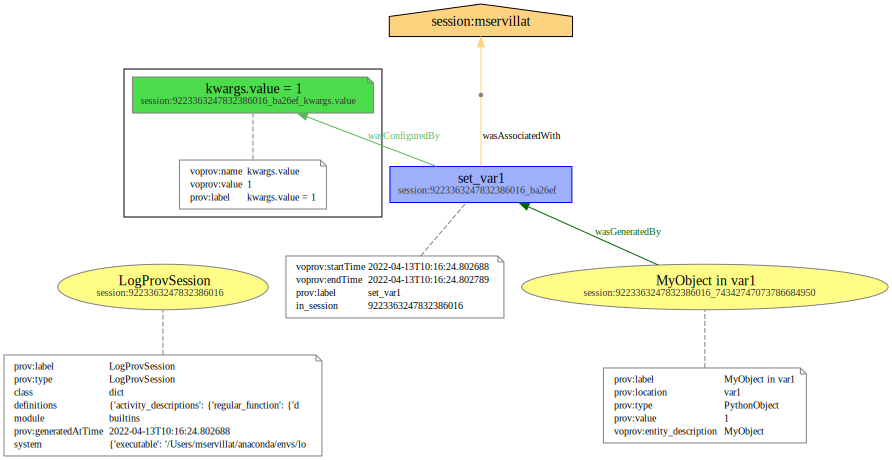

In [13]:
show_prov(start, end); SVG(filename=logname + '.svg')

In [14]:
prov_capture.sessions

[9223363247832386016]

In [15]:
c1.__dict__

{'var1': 1, 'var2': 0, 'args': (Class1 instance,), 'kwargs': {'value': 1}}